In [1]:
#Importing modules
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, date, time
import pandas as pd
import os
import zipfile
pd.set_option('mode.chained_assignment', None)
from pyproj import Geod
import math
from sklearn.preprocessing import MinMaxScaler
import statistics
from scipy.stats import zscore
#!pip install hdbscan
import hdbscan
from functools import reduce
import operator
from sklearn.metrics import silhouette_samples, silhouette_score
import difflib

In [2]:
#Import data from files
files=os.listdir('stations')
stations=[]
for fileName in files:
    #Load data    
    try:
        file=np.loadtxt('stations/'+fileName, delimiter=",")
        df = pd.DataFrame(file, columns = ['Time', 'xPos', 'yPos', 'xUncertainty', 'yUncertainty'])
        #Ignore stations with high uncertainty
        if df['xUncertainty'].mean()>3 or df['yUncertainty'].mean()>3:
            continue
        
        #Drop unnecessary columns
        df2=df.drop(columns=['xUncertainty', 'yUncertainty'])
        
        #Add additional columns to station data
        df2['StationName']=fileName[:-4]
        df2['Lat']=""
        df2['Lon']=""
        stations.append(df2)
    except:
        continue
#Load key that describes station locations and station names
lonLat=np.loadtxt('lonLat.txt', delimiter=",").T
with open('names.txt', 'r') as f:
    lonLatKeyInit=f.readlines()
f.close()
lonLatKey=[]
for item in lonLatKeyInit:
    item=item.strip()
    lonLatKey.append(item)

In [3]:
#Convert to data organized by timestep instead of by station

g = Geod(ellps='clrk66') #used for calculating azimuth/magnitude

#Collect desired time period
perfectTimeSeries=np.arange(1995.99958 +(0.00274*5110), 1995.99958 +(0.00274*8760),0.00274) #2010-2020
testPoint=2010.63 #start time
difference_array = np.absolute(perfectTimeSeries-testPoint)
index = difference_array.argmin()
perfectTimeSeries=perfectTimeSeries#[index:index+300] #how far to go forward (in days)


timesTotal=[]
for value in range(0,len(perfectTimeSeries)):
    timeOfficial=round(perfectTimeSeries[value], 5) #this is the timestep we're using
    times = pd.DataFrame()
    for value2 in range(0, len(stations)):
        #Find which stations have data at that timestep
        f = stations[value2]['Time']==timeOfficial
        indices = f[f].index
        if (len(list(indices)))==0:
            continue
        time=stations[value2].iloc[indices]
        
        #Add on location of that station
        station=time.iloc[0]['StationName']
        stationIndex=np.where(np.asarray(lonLatKey)==station)[0][0]
        time['Lat']=lonLat[1][stationIndex]
        time['Lon']=lonLat[0][stationIndex]
        
        #Calculate magnitude and azimuth at that station
        dLat = (time['yPos']/6378137) * 180/math.pi
        dLon = (time['xPos']/(6378137*math.cos(math.pi*time['Lat']/180)))* 180/math.pi
        az12,az21,dist = g.inv(time['Lon'],time['Lat'],time['Lon']+dLon,time['Lat']+dLat)
        time['Mag']=dist
        time['Azimuth']=az12
        
        #Drop unnecessary columns and reorganize
        time=time.drop(columns=['StationName'])
        time=time[['Time', 'xPos', 'yPos', 'Mag', 'Azimuth', 'Lat', 'Lon']]
        times=pd.concat([times, time])
    timesTotal.append(times)
    if value % 10 == 0: #this just keeps track that we're making progress through the data
        print(value)


0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
2

In [23]:
#Run clustering algorithm 

#Prep needed inputs
def cluster(cluster_size, metric, samples, showFig):
    timesOneMatrix = pd.concat(timesTotal)
    timesNP=timesOneMatrix.to_numpy()
    labelsList=list()
    dataPerWeek=list()
    labelsPerWeek=list()
    dataList=list()
    indicesList=list()
    for i in range(450,len(np.unique(timesNP[:,0]))):
        #Prep data for clustering
        data=timesTotal[i].to_numpy()
        if len(data)<cluster_size*samples: # Make sure there is a significant amount of data
            continue
        #Calculate outliers
        def modified_zscore(data, consistency_correction=1.4826):
            median = np.median(data)
            deviation_from_med = np.array(data) - median
            mad = np.median(np.abs(deviation_from_med))
            mod_zscore = deviation_from_med/(consistency_correction*mad)
            return mod_zscore
        mask = np.absolute(modified_zscore([x[1] for x in data])) >2
        mask2 = np.absolute(modified_zscore([x[3] for x in data])) > 2
        mask = np.logical_or(mask, mask2)
        k=0
        for sub_list in list(zip(*data)):
            indices=[i for i, x in enumerate(mask) if ~x]
            indicesList.append(indices)
            dataList.append(data)
        if i% 7==0:
            out = list(reduce(operator.iand, map(set, indicesList))) #only including elements that aren't ever an outlier during the week
            dataForPlotting=list()
            for j in np.arange(0,7):
                dataDF=pd.DataFrame()
                for sub_list in list(zip(*dataList[j])):
                    sub_list=[sub_list[i] for i in out]
                    dataDF[str(k)]=sub_list
                    k+=1
                data=dataDF.to_numpy()
                if len(data)<cluster_size*samples: # Make sure there is a significant amount of data
                    continue
                dataForPlotting.append(data)
                #Normalize the data
                dataforNorm=pd.DataFrame()
                k=0
                for sub_list in list(zip(*data)): #Dropping Time, xPos, yPos
                    if k>=3:
                        dataforNorm[str(k-3)]=sub_list
                    k+=1
                norm = MinMaxScaler()
                dataNorm=norm.fit_transform(dataforNorm)

                #Run clustering
                clusterer = hdbscan.HDBSCAN(min_cluster_size=cluster_size, gen_min_span_tree=True, metric=metric, min_samples=samples).fit(dataNorm)
                labels=clusterer.labels_
                labelsList.append(labels)
            if len(dataForPlotting)==0:
                continue
            dataForPlottingAvg = np.mean(dataForPlotting, 0)

            #Every week, average the labels made in the clustering
            #Ignore clusters with really small magnitude
            nClusters=max(labels)+1
            for m in range(0,nClusters):
                k=0
                dataDF=pd.DataFrame()
                for sub_list in zip(*data):
                    indices=[i for i, x in enumerate(labels) if x==m]
                    sub_list=[sub_list[i] for i in indices]
                    k+=1
                    dataDF[str(k)]=sub_list
                if abs((dataDF['2'].mean()+dataDF['3'].mean())/2)<0.2: 
                    labels[indices] = -1

            #Calculate most common cluster and save data
            labelsAvg = [statistics.mode(sub_list) for sub_list in zip(*labelsList)]
            dataPerWeek.append(data)
            labelsPerWeek.append(labelsAvg)

            ##Show results for week
            if showFig=="True":
                figAverage, (ax1) = plt.subplots(1,1, figsize=(10,8)) 
                ax1.quiver([x[-1] for x in dataForPlottingAvg], [x[-2] for x in dataForPlottingAvg], [x[1] for x in dataForPlottingAvg], [x[2] for x in dataForPlottingAvg])
                sc=ax1.scatter([x[-1] for x in dataForPlottingAvg], [x[-2] for x in dataForPlottingAvg], c=labelsAvg, edgecolor="k")
                ax1.set_title(np.unique(timesNP[:,0])[i])
                ##Create legend
                lp = lambda i: plt.plot([],color=sc.cmap(sc.norm(i)), mec="none", label="Cluster {:g}".format(i), ls="", marker="o")[0]
                handles = [lp(i) for i in np.unique(labels)]
                plt.legend(handles=handles)
            labelsList=list()
            dataList=list()
            indicesList=list()
        if i==650:
            break
    return [dataPerWeek, labelsPerWeek]


In [5]:
overallSilhouettes=[]
hyperparameters=[]
ratiosFullList=[]
counter=0
print("0/"+str((3*len(np.arange(10,70,10))-1)))
for cluster_size in np.arange(10,70,10):
    for metric in ['euclidean','manhattan', 'chebyshev']:
        samples=1
        print(counter)
        counter+=1
        [dataPerWeek, labelsPerWeek]=cluster(cluster_size, metric, samples, "False")
        overallSilhouette=0
        meanSum=0
        for i in np.arange(0,len(dataPerWeek)):
            if len(np.unique(labelsPerWeek[i]))==0 or len(np.unique(labelsPerWeek[i]))==1:
                continue
            silhouette_avg = silhouette_score(dataPerWeek[i], labelsPerWeek[i])
            overallSilhouette=overallSilhouette+silhouette_avg
            meanSum+=1
        if meanSum==0:
            continue
        overallSilhouette=overallSilhouette/meanSum
        overallSilhouettes.append(overallSilhouette)

        #consistent time clustering
        ratios=0
        trueLength=len(labelsPerWeek)
        for count in np.arange(1,len(labelsPerWeek)):                   
            if len(np.unique(labelsPerWeek[count]))==1: #nothing is clustered
                ratio=0
                trueLength=trueLength-1
                continue
            sm=difflib.SequenceMatcher(None,labelsPerWeek[count],labelsPerWeek[count-1])
            ratio=sm.ratio()
            ratios=ratios+ratio
        ratios=ratios/trueLength
        ratiosFullList.append(ratios)
        hyperparameters.append([cluster_size, metric, samples])
hyperparameters=hyperparameters[1:]
overallSilhouettes=overallSilhouettes[1:]
ratiosFullList=ratiosFullList[1:]

0/17
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17


In [6]:
maxIndex=np.argpartition(overallSilhouettes, -4)[-4:]
print(maxIndex)
for item in maxIndex:
    print(hyperparameters[item])
    print(overallSilhouettes[item])
    
maxIndexRatios=np.argpartition(ratiosFullList, -4)[-4:]
print(maxIndexRatios)
for item in maxIndexRatios:
    print(hyperparameters[item])
    print(ratiosFullList[item])
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

maxCombo=np.argpartition([a*b for a,b in zip(NormalizeData(overallSilhouettes),NormalizeData(ratiosFullList))],-4)[-4:]
print(maxCombo)
for item in maxCombo:
    print(hyperparameters[item])
    print(ratiosFullList[item])
    print(overallSilhouettes[item])


[12 11 14 16]
[50, 'manhattan', 1]
0.48152193953802847
[50, 'euclidean', 1]
0.4870378049723141
[60, 'euclidean', 1]
0.5123578880055442
[60, 'chebyshev', 1]
0.5326807494085185
[2 3 0 1]
[20, 'euclidean', 1]
0.27898071690964676
[20, 'manhattan', 1]
0.2802374778661777
[10, 'manhattan', 1]
0.32805482053945545
[10, 'chebyshev', 1]
0.33482777377837275
[6 5 9 8]
[30, 'manhattan', 1]
0.19870003142354492
0.13353505219415032
[30, 'euclidean', 1]
0.190086835019261
0.15126046955088568
[40, 'manhattan', 1]
0.13604212555279502
0.3282864755443998
[40, 'euclidean', 1]
0.14053440286396937
0.2897048299812858


/tmp/ipykernel_1102/19093544.py:84: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  figAverage, (ax1) = plt.subplots(1,1, figsize=(10,8))


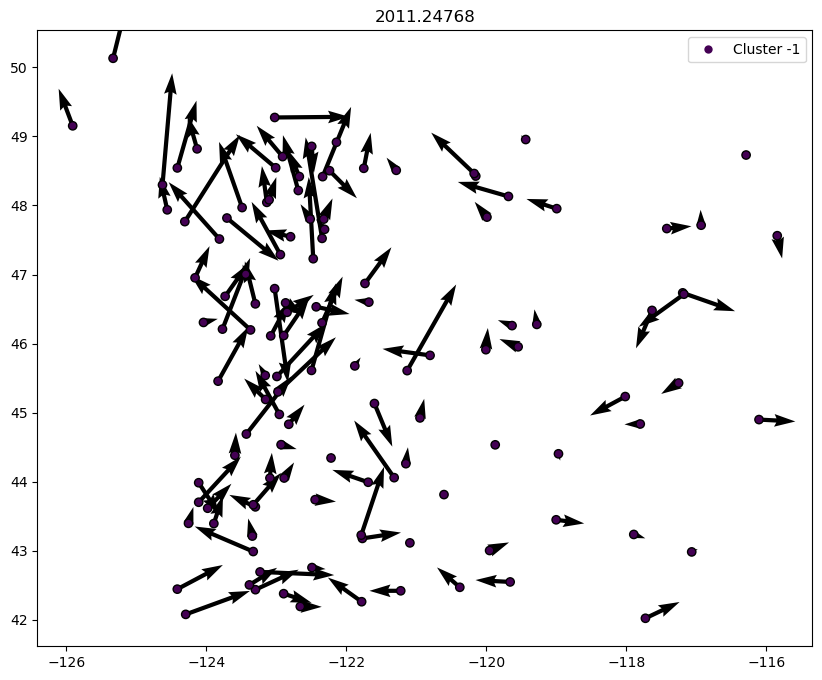

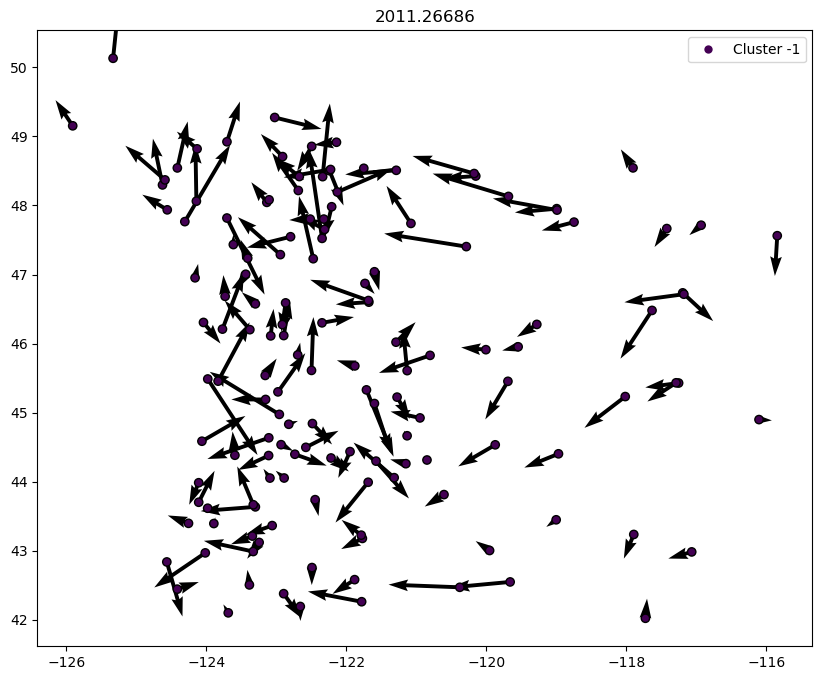

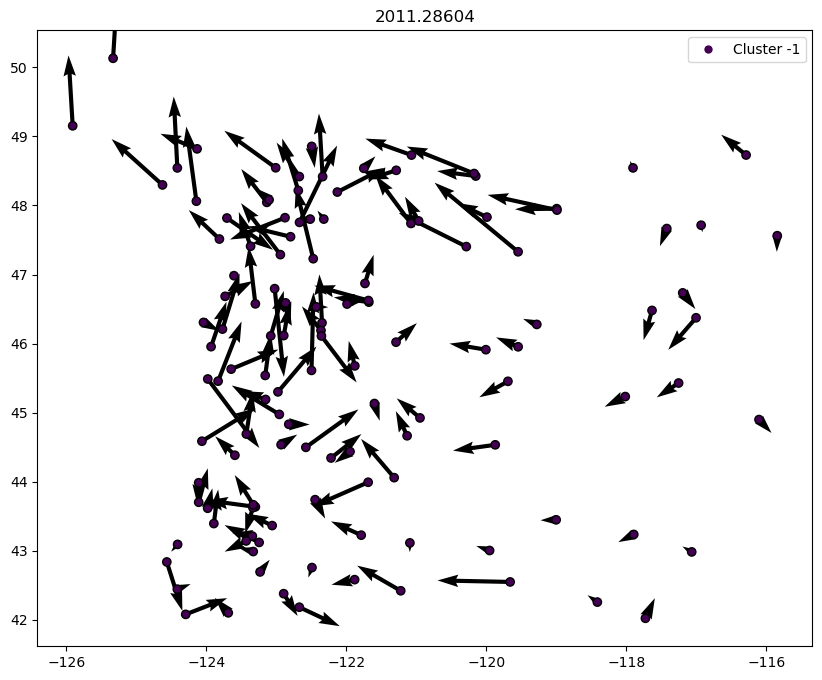

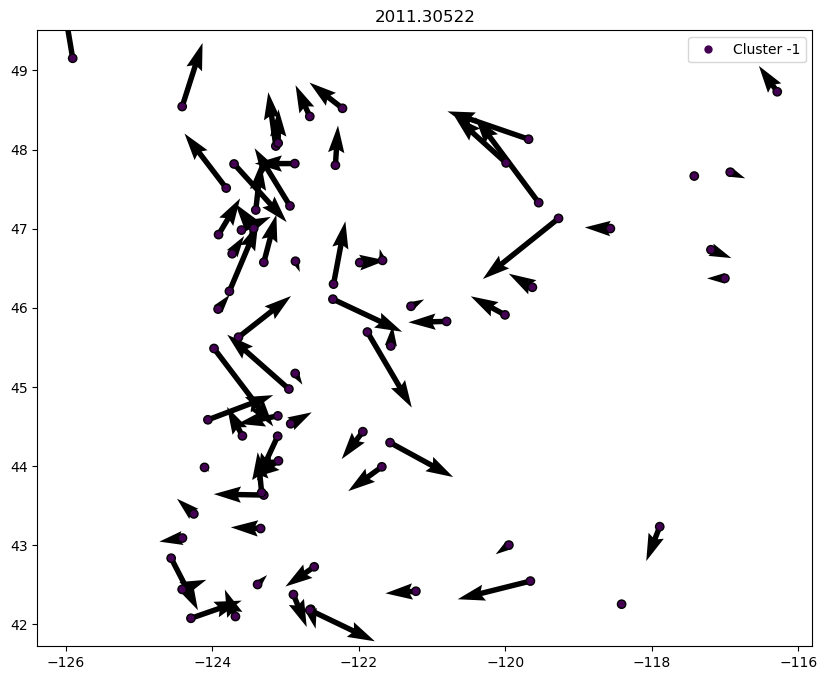

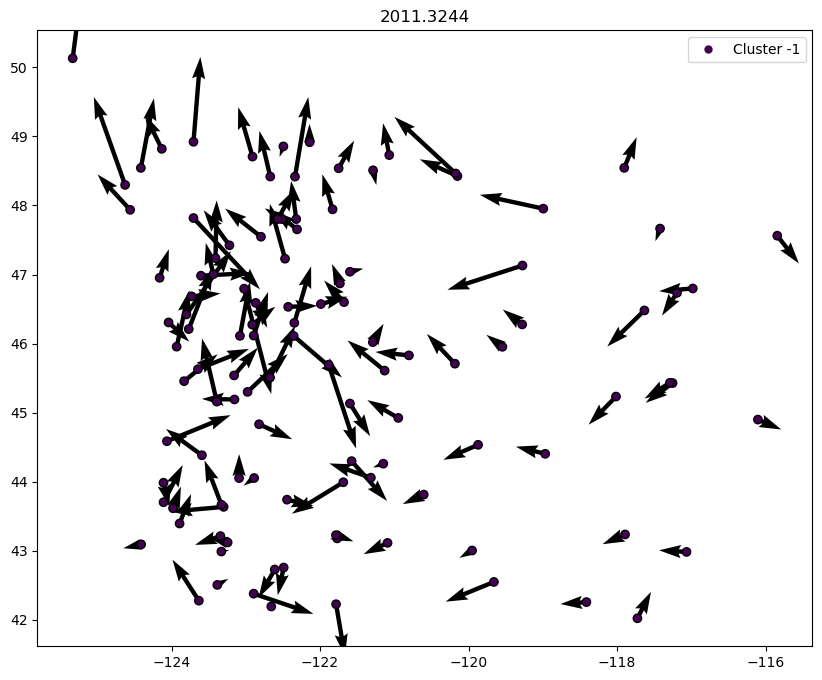

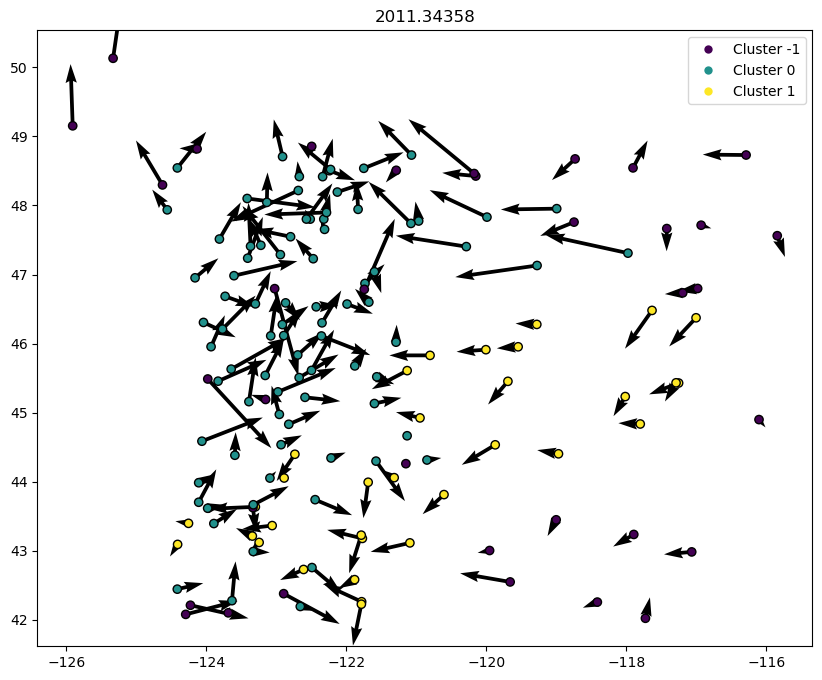

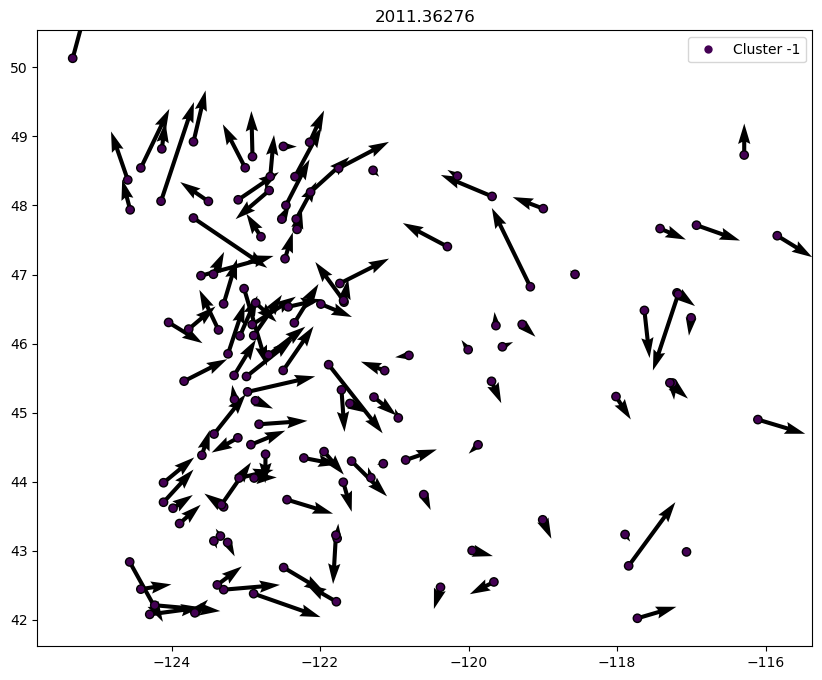

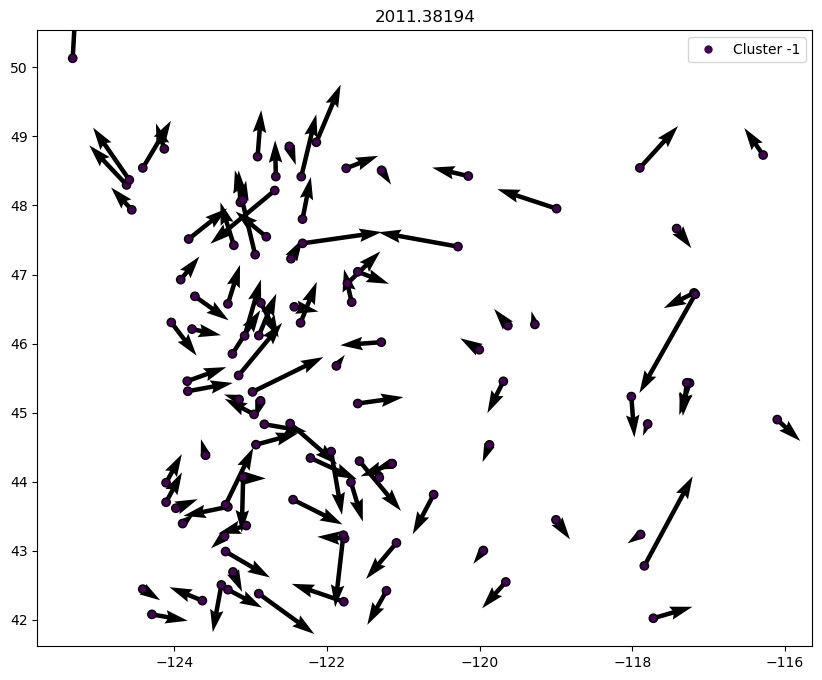

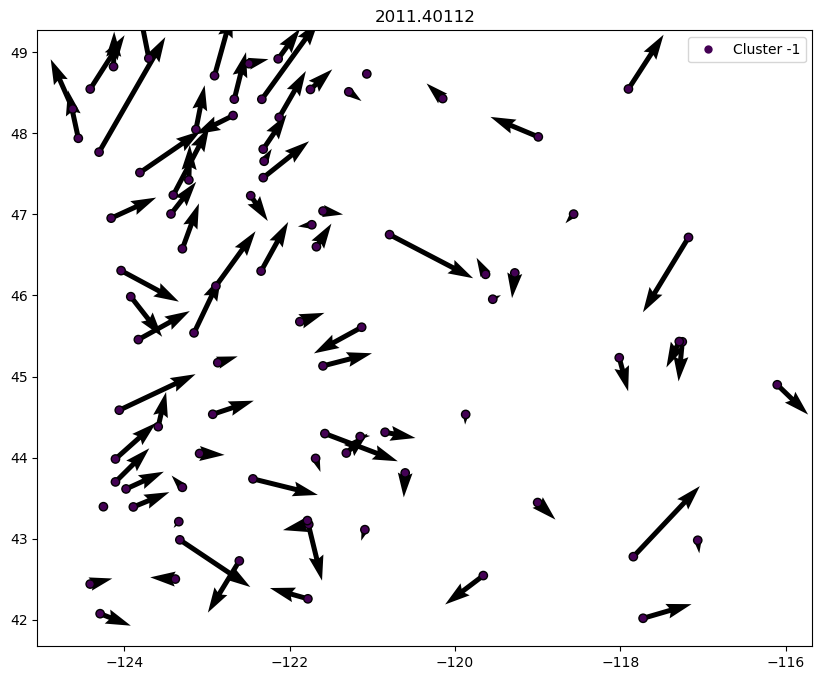

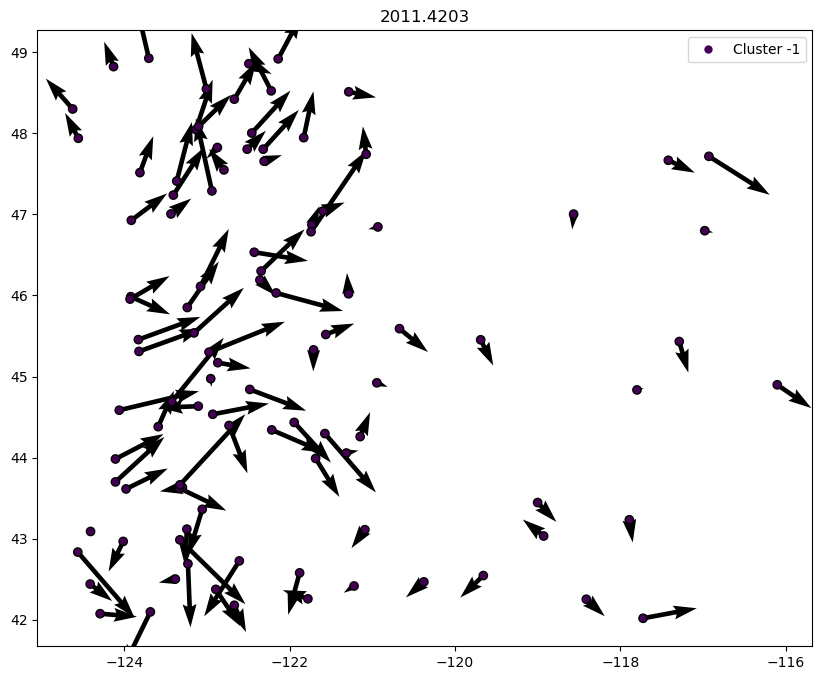

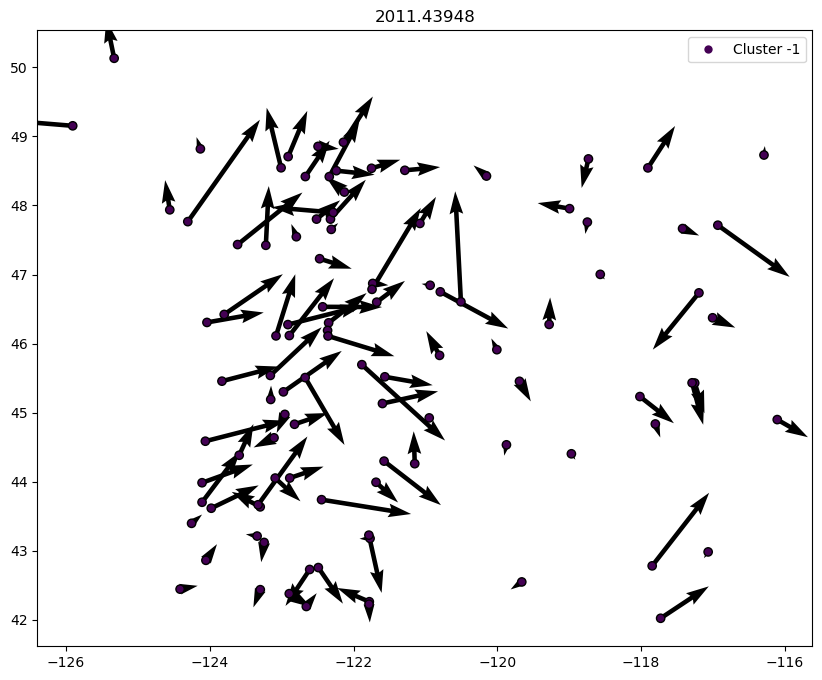

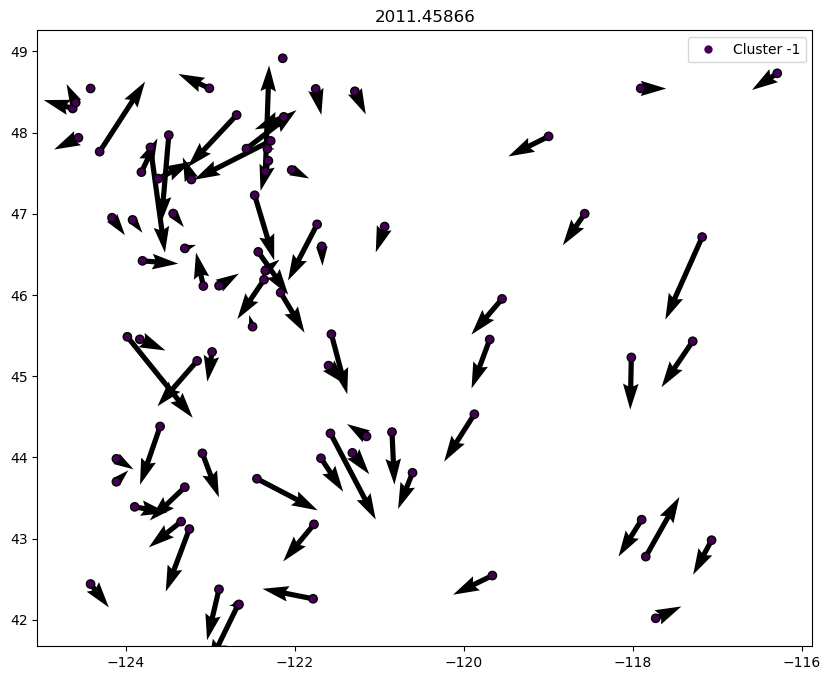

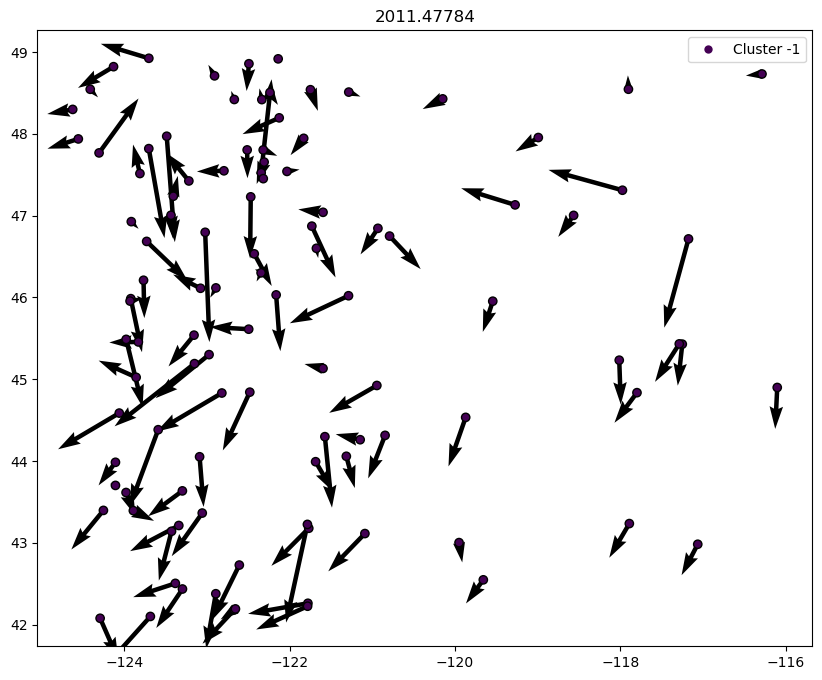

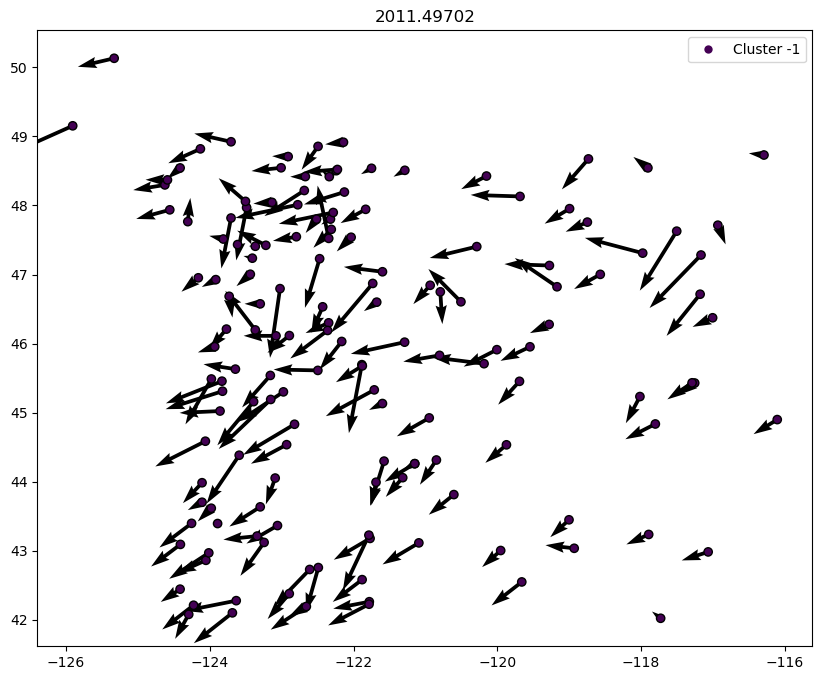

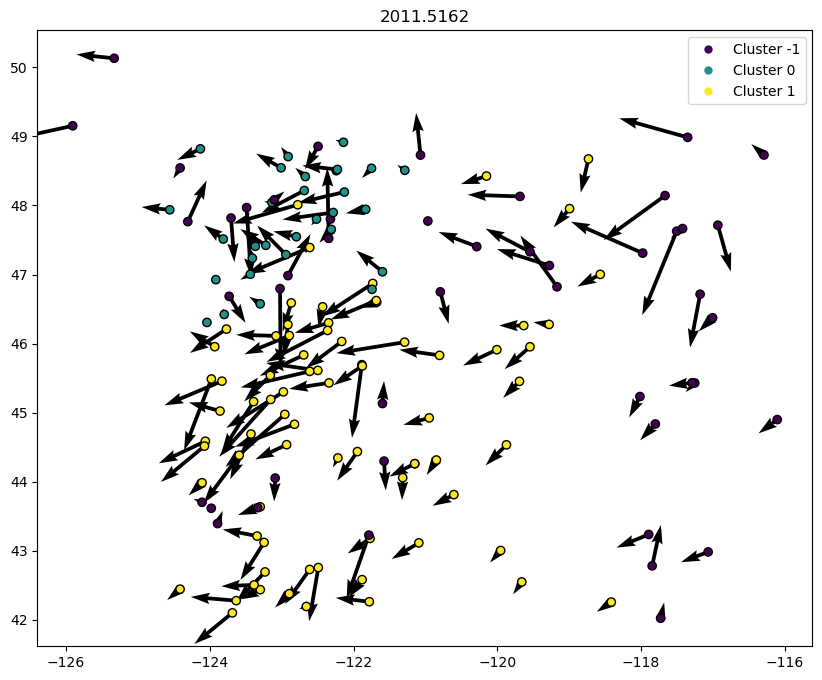

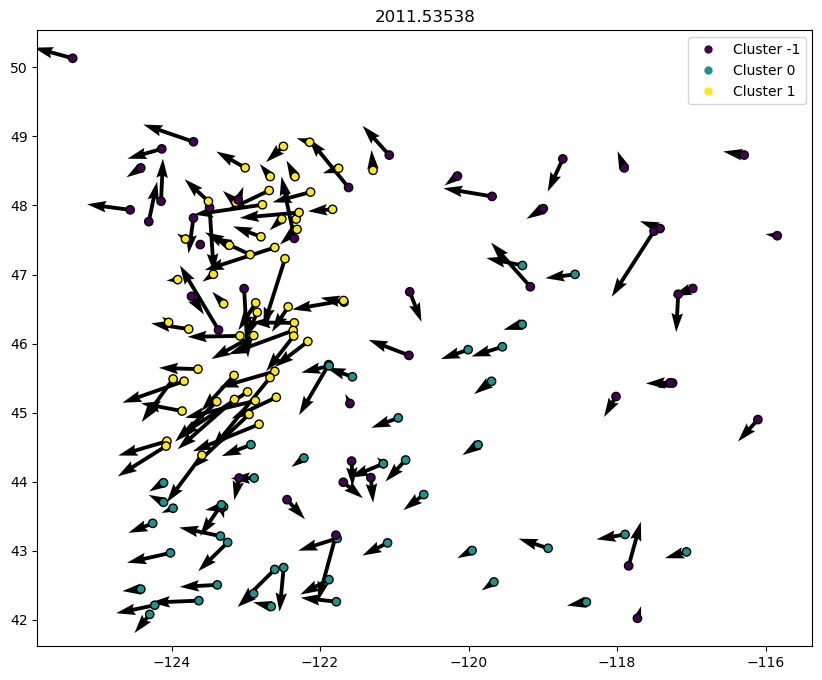

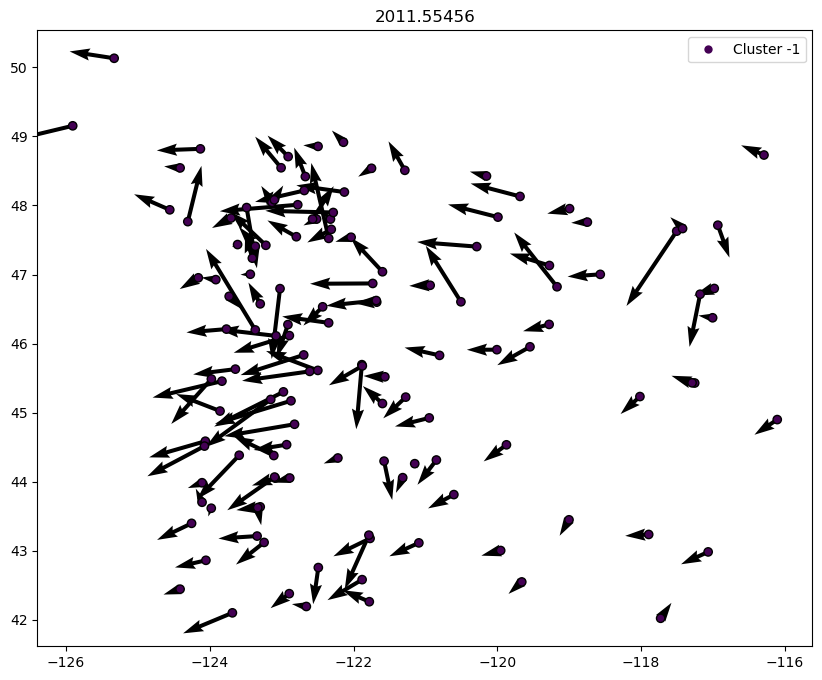

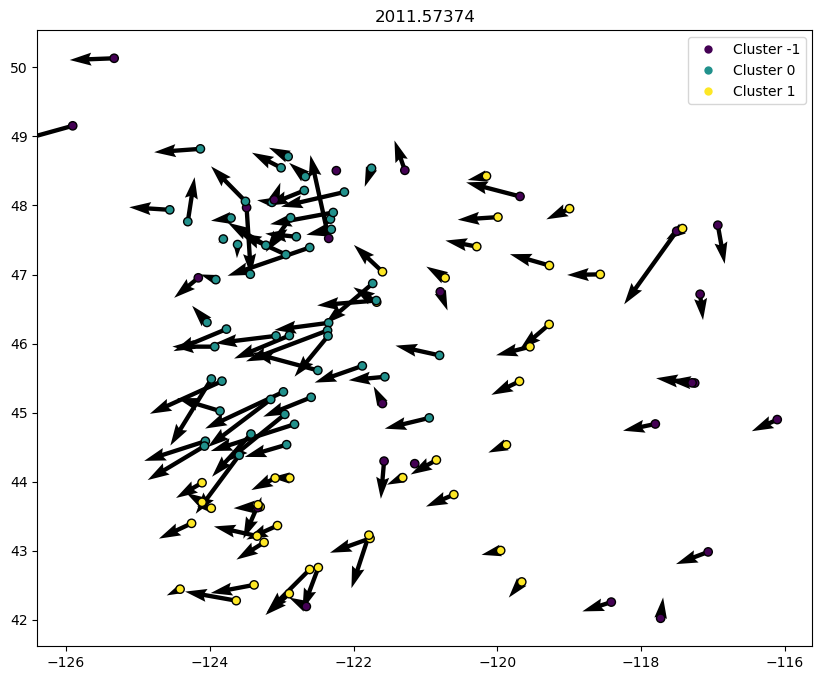

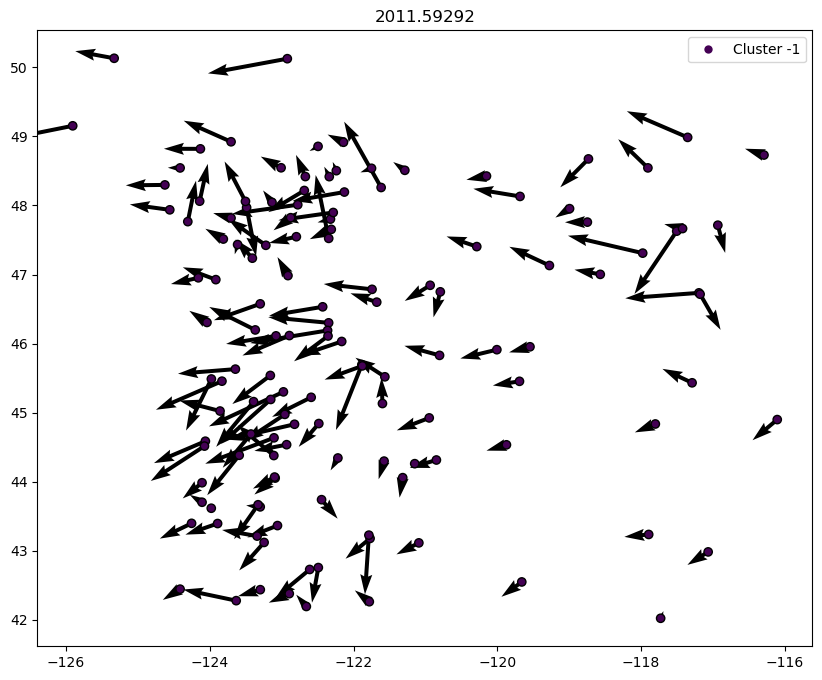

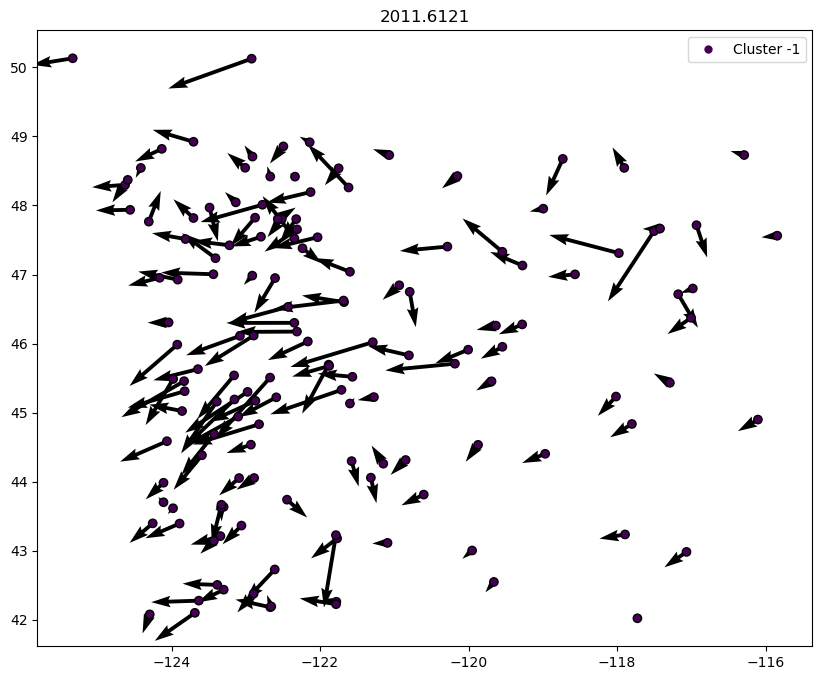

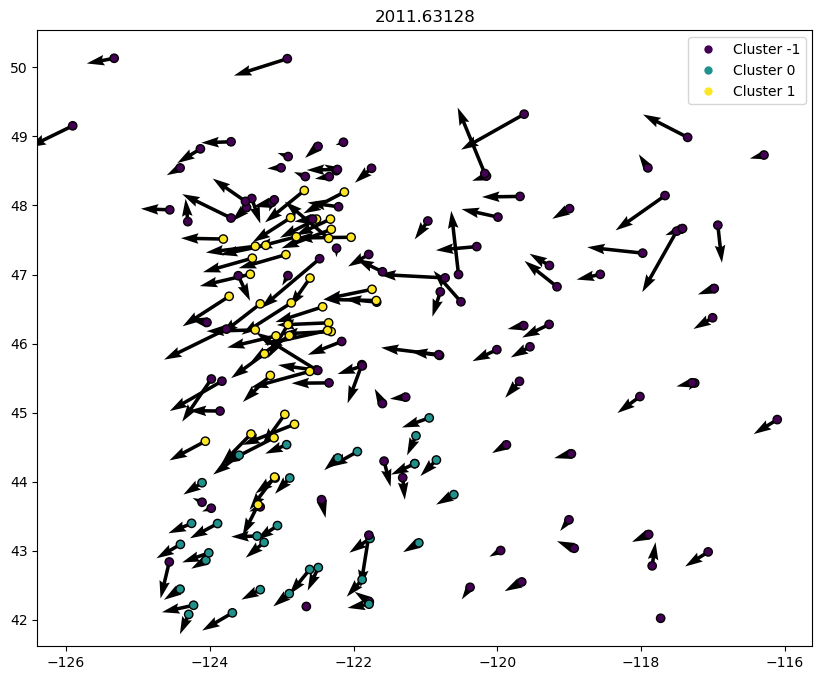

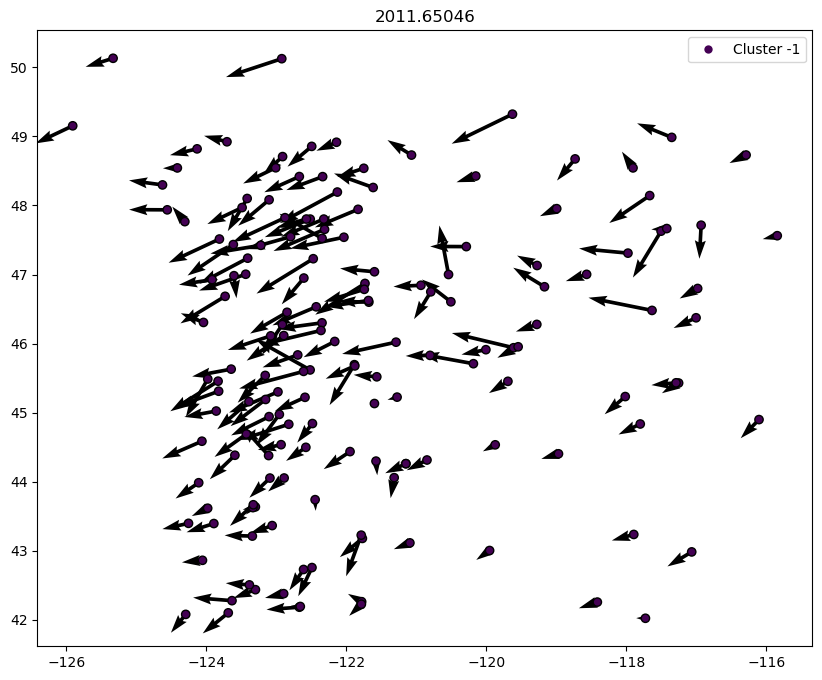

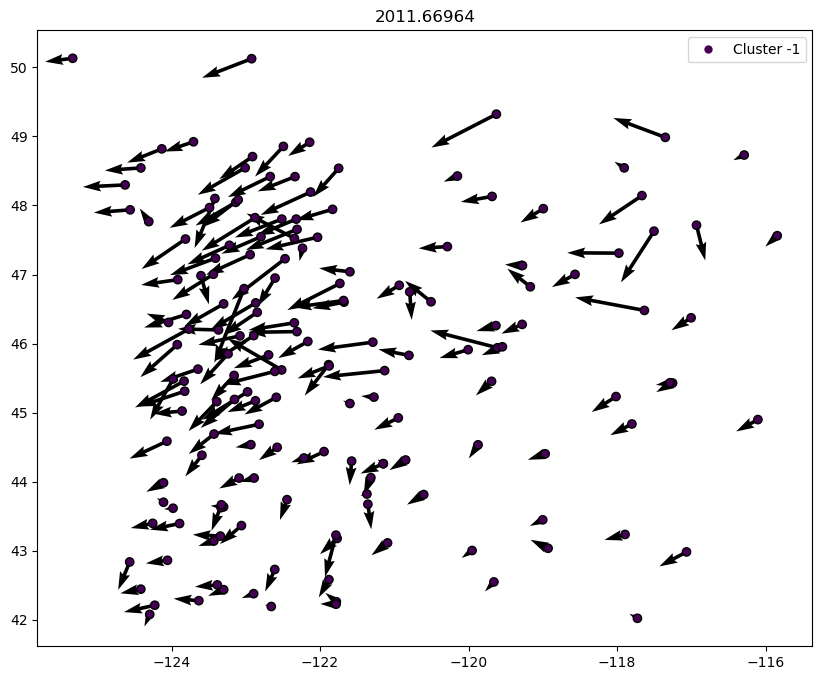

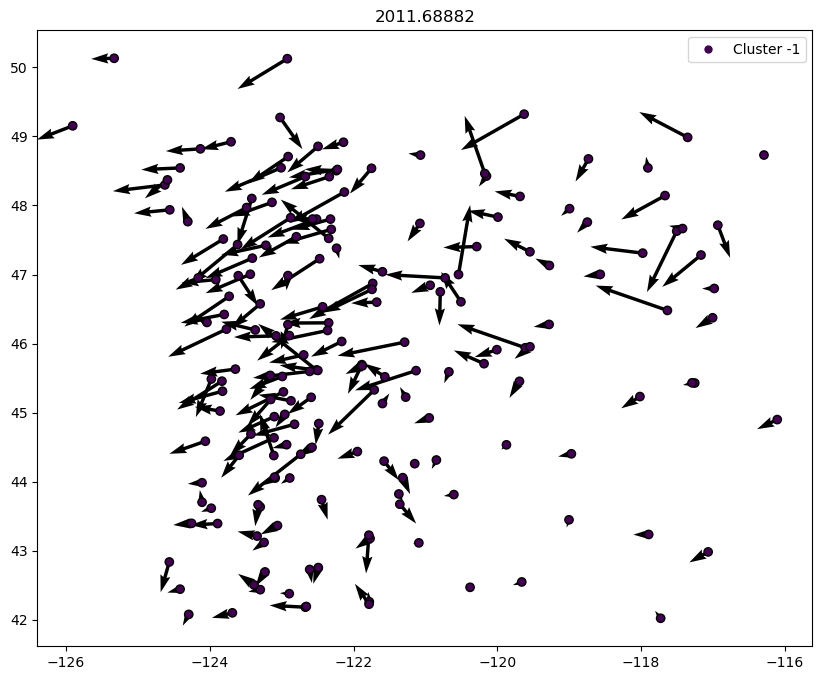

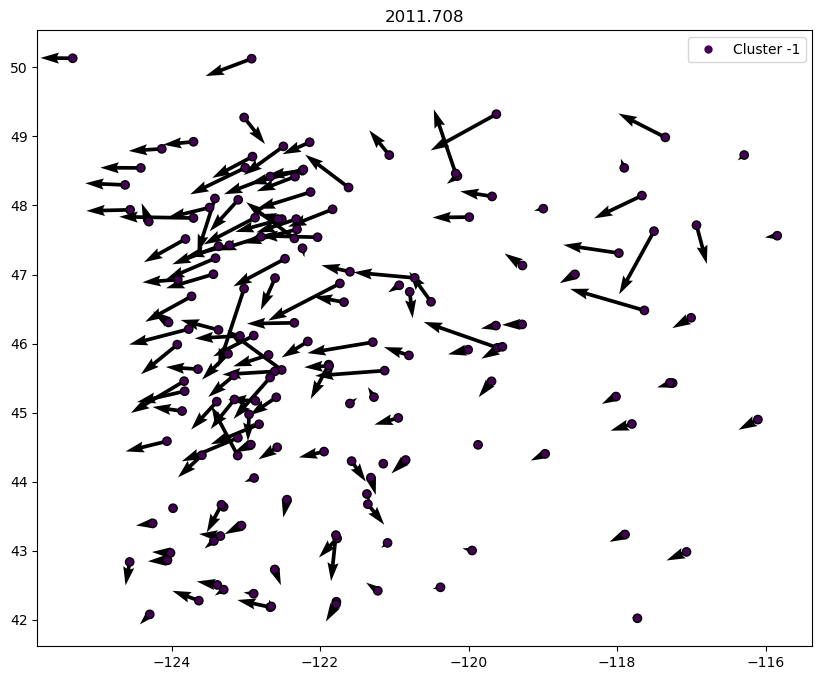

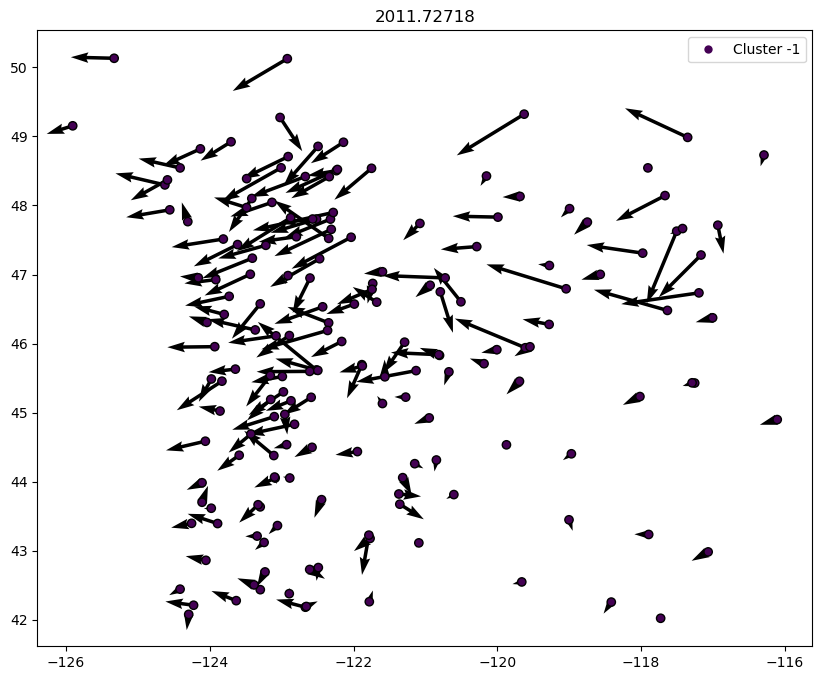

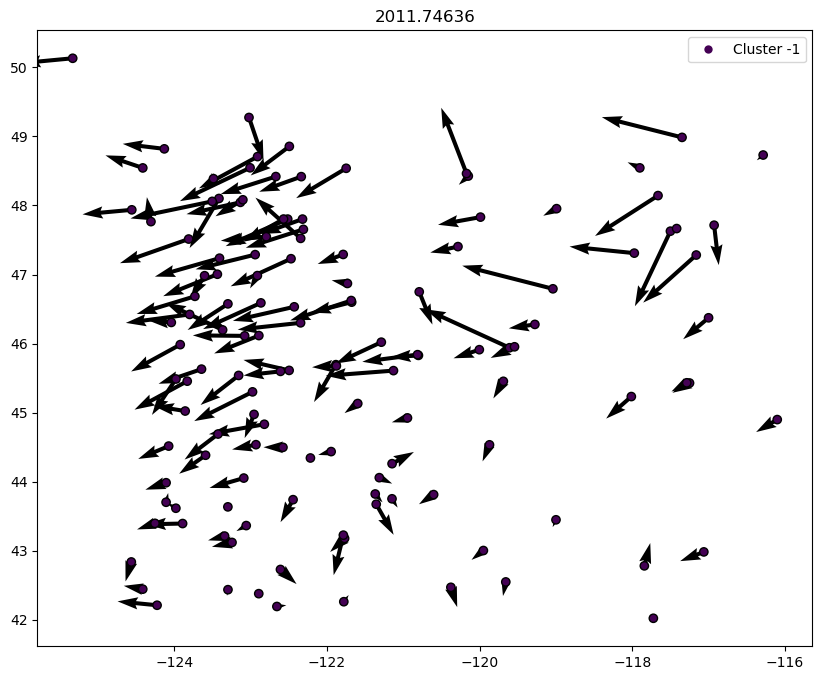

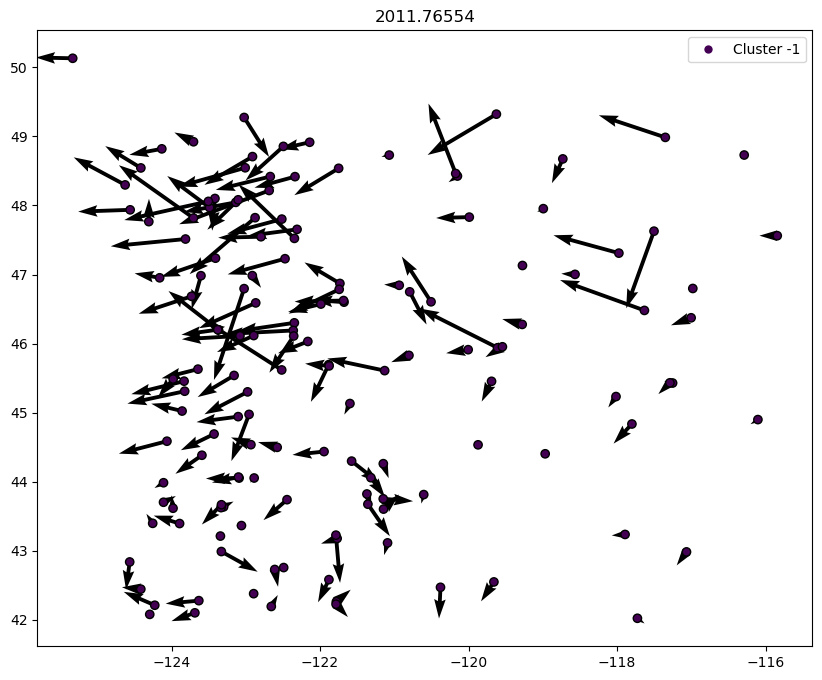

In [24]:
##Warning-- do not run this on all of the data, it will crash (because of output graphs)
#[dataPerWeek, labelsPerWeek]=cluster(30, 'euclidean', 1, "True")